## Replacing empty values with the mean of their respective columns

In [20]:
import pandas as pd

# Load the dataset
driver_locations = pd.read_csv('../data/driver_locations.csv')

# Replace empty values in the dataframe with the mean of their respective columns
driver_locations = driver_locations.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x.fillna(x.mode()[0]))

# Save the updated DataFrame to a new CSV file
driver_locations.to_csv('../data/driver_locations.csv', index=False)

# Verify changes
print(driver_locations.head())
print(driver_locations.isnull().sum())


   id  TripID  driver_id driver_action       lat       lng
0   1  392001     243828      accepted  6.602207  3.270465
1   2  392001     243588      rejected  6.592097  3.287445
2   3  392001     243830      rejected  6.596133  3.281784
3   4  392001     243539      rejected  6.596142  3.280526
4   5  392001     171653      rejected  6.609232  3.288800
id               0
TripID           0
driver_id        0
driver_action    0
lat              0
lng              0
dtype: int64


## Split data into training and hold-out set

In [23]:
from sklearn.model_selection import train_test_split

# Load your processed dataset
completed = pd.read_csv('../data/nb8_updated.csv')

# Load the driver actions data
driver_locations = pd.read_csv('../data/driver_locations.csv')

# Merge the datasets on 'TripID'
data = pd.merge(completed, driver_locations, on='TripID')

# Split the data into training and hold-out sets based on 'order_id'
order_ids = data['TripID'].unique()
train_order_ids, holdout_order_ids = train_test_split(order_ids, test_size=0.2, random_state=42)

train_data = driver_locations[data['TripID'].isin(train_order_ids)]
holdout_data = driver_locations[data['TripID'].isin(holdout_order_ids)]

# Verify the split
print("Training set size:", train_data.shape)
print("Hold-out set size:", holdout_data.shape)


Training set size: (1106106, 6)
Hold-out set size: (280972, 6)


In [ ]:
## Constructing ground truth Completed Partially Directed Acyclic Graph (CPDAG)

In [57]:
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.cit import fisherz
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import networkx as nx
from graphviz import Source
import matplotlib.pyplot as plt

# Step 1: Encode the 'driver_action' column if it's categorical
le = LabelEncoder()
train_data['driver_action'] = le.fit_transform(train_data['driver_action'])

# Step 2: Impute missing values, if any
imputer = SimpleImputer(strategy='mean')
train_data_imputed = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)

# Step 3: Ensure all data is numeric
train_data_numeric = train_data_imputed.astype(float)

# Step 4: Convert to NumPy array
data_array = train_data_numeric.to_numpy()

def construct_causal_graph(data, significance_level):
    """
    Constructs a causal graph using the PC algorithm.
    """
    try:
        # Correctly pass 'alpha' as a keyword argument
        cg = pc(data, indep_test=fisherz, alpha=significance_level, verbose=True, early_stopping=0.1, knowledge=None)
        cpdag = dag2cpdag(cg.G)
        return cpdag
    except Exception as e:
        print(f"Error constructing causal graph: {e}")
        return None

def cpdag_to_nx_graph(cpdag):
    """
    Converts a CPDAG to a networkx DiGraph for visualization.
    """
    G = nx.DiGraph()
    for edge in cpdag.edges():
        G.add_edge(*edge)
    return G

def render_causal_graph(cpdag, filename="causal_graph"):
    """
    Renders the CPDAG using graphviz.
    """
    dot_str = cpdag.to_dot()
    graph = Source(dot_str)
    graph.render(filename=filename, format='png', cleanup=True, directory='./', view=False)

def draw_graph(G):
    """
    Draws the networkx graph.
    """
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
    directed_edges = [edge for edge in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,_ in directed_edges], edge_color='black', arrows=True)
    nx.draw_networkx_labels(G, pos, font_weight='bold')
    plt.show()

if __name__ == "__main__":
    significance_level = 0.05
    
    try:
        ground_truth_cpdag = construct_causal_graph(data_array, significance_level)
        if ground_truth_cpdag is not None:
            print("Ground truth CPDAG constructed successfully.")
            render_causal_graph(ground_truth_cpdag)
            
            # Optionally, convert CPDAG to networkx graph for further analysis or visualization
            nx_graph = cpdag_to_nx_graph(ground_truth_cpdag)
            print("Converted CPDAG to networkx DiGraph.")
            
            # Visualize the networkx graph
            draw_graph(nx_graph)
    except Exception as e:
        print(f"Error: {e}")

  0%|          | 0/6 [00:00<?, ?it/s]

0 dep 1 | () with p-value 0.000000

0 dep 2 | () with p-value 0.010328

0 ind 3 | () with p-value 0.894848

0 dep 4 | () with p-value 0.000000

0 dep 5 | () with p-value 0.000148

1 dep 0 | () with p-value 0.000000

1 dep 2 | () with p-value 0.013984

1 ind 3 | () with p-value 0.326331

1 dep 4 | () with p-value 0.000000

1 dep 5 | () with p-value 0.002622

2 dep 0 | () with p-value 0.010328

2 dep 1 | () with p-value 0.013984

2 ind 3 | () with p-value 0.580985

2 dep 4 | () with p-value 0.000223

2 dep 5 | () with p-value 0.014575

3 ind 0 | () with p-value 0.894848

3 ind 1 | () with p-value 0.326331

3 ind 2 | () with p-value 0.580985

3 ind 4 | () with p-value 0.491618

3 ind 5 | () with p-value 0.219573

4 dep 0 | () with p-value 0.000000

4 dep 1 | () with p-value 0.000000

4 dep 2 | () with p-value 0.000223

4 ind 3 | () with p-value 0.491618

4 dep 5 | () with p-value 0.000000

5 dep 0 | () with p-value 0.000148

5 dep 1 | () with p-value 0.002622

5 dep 2 | () with p-value 0.

In [ ]:
## Constructing causal graph using the PC algorithm

/tmp/ipykernel_12230/2622748608.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_relevant['TripStartTime'] = pd.to_datetime(data_relevant['TripStartTime'])
/tmp/ipykernel_12230/2622748608.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_relevant['time_of_day'] = data_relevant['TripStartTime'].dt.hour


  0%|          | 0/5 [00:00<?, ?it/s]

Causal graph constructed successfully.


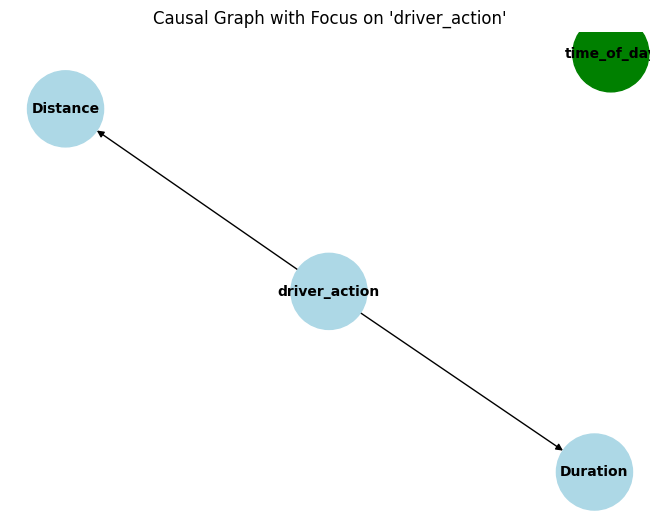

Edges in the causal graph:
[('driver_action', 'Distance'), ('driver_action', 'Duration')]


In [11]:
from pgmpy.estimators import PC

# Load your processed dataset
data = pd.read_csv('../data/nb8_updated.csv')

# Load the driver actions data
driver_actions = pd.read_csv('../data/driver_locations_updated.csv')

# Merge the datasets on 'TripID'
data = pd.merge(data, driver_actions, on='TripID')

# Encode the 'driver_action' column if it's categorical
le = LabelEncoder()
data['driver_action'] = le.fit_transform(data['driver_action'])

# Focus on the relevant variables
relevant_columns = ['Distance', 'Duration', 'TripStartTime', 'driver_action']
data_relevant = data[relevant_columns]

# Extract the hour of the day for the trip start time
data_relevant['TripStartTime'] = pd.to_datetime(data_relevant['TripStartTime'])
data_relevant['time_of_day'] = data_relevant['TripStartTime'].dt.hour

# Drop the original 'TripStartTime' column as we now have 'time_of_day'
data_relevant = data_relevant.drop(columns=['TripStartTime'])

# Impute missing values, if any
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data_relevant), columns=data_relevant.columns)

# Ensure all data is numeric
data_numeric = data_imputed.astype(float)

# Convert to NumPy array
data_array = data_numeric.to_numpy()

# Function to construct the causal graph using the PC algorithm
def construct_causal_graph(data, columns, target, significance_level=0.05):
    """
    Constructs a causal graph using the PC algorithm, focusing on the target variable.
    """
    try:
        # Convert the data back to a DataFrame for PC algorithm in pgmpy
        data_df = pd.DataFrame(data, columns=columns)
        
        # Use the PC algorithm to estimate the structure
        pc = PC(data_df)
        model = pc.estimate(significance_level=significance_level)
        
        # Focus on the edges directly connected to the target variable
        target_edges = [(u, v) for u, v in model.edges() if u == target or v == target]
        
        return model, target_edges
    except Exception as e:
        print(f"Error constructing causal graph: {e}")
        return None, None

# Construct the causal graph
target_variable = 'driver_action'
columns = ['Distance', 'Duration', 'time_of_day', 'driver_action']
ground_truth_graph, target_edges = construct_causal_graph(data_array.tolist(), columns, target_variable)

if ground_truth_graph is not None:
    print("Causal graph constructed successfully.")
    
    # Convert the pgmpy model to a networkx graph for visualization
    nx_graph = nx.DiGraph()
    for edge in target_edges:
        nx_graph.add_edge(*edge)  # Unpack the tuple when adding edges
    
    # Ensure 'time_of_day' is included as a node in the graph with appropriate attributes
    for column in columns:
        if column != target_variable:
            nx_graph.add_node(column, color='lightblue', size=2000)
    
    # Assign colors to nodes
    node_colors = ['lightblue' if node == target_variable else 'green' if node == 'time_of_day' else 'lightblue' for node in nx_graph.nodes()]
    
    # Draw the graph using matplotlib
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold')
    plt.title("Causal Graph with Focus on 'driver_action'")
    plt.show()
    
    # Print edges for inspection
    print("Edges in the causal graph:")
    print(target_edges)
else:
    print("Failed to construct the causal graph.")
